In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload

import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy
    
from math_module import xp, _scipy, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

dm1_flat = fits.getdata('spc_wide_band4_flattened_dm1.fits')
dm2_flat = fits.getdata('spc_wide_band4_flattened_dm2.fits')

import copy


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


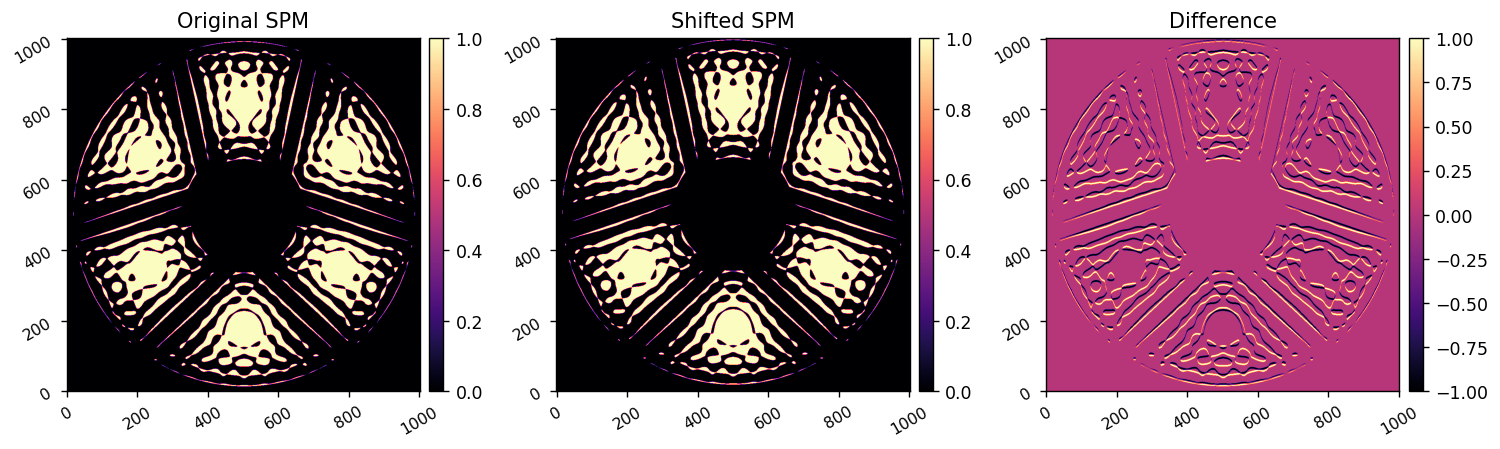

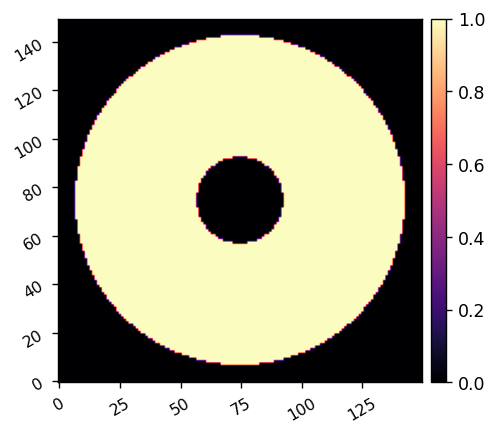

1.483451375154414e-06


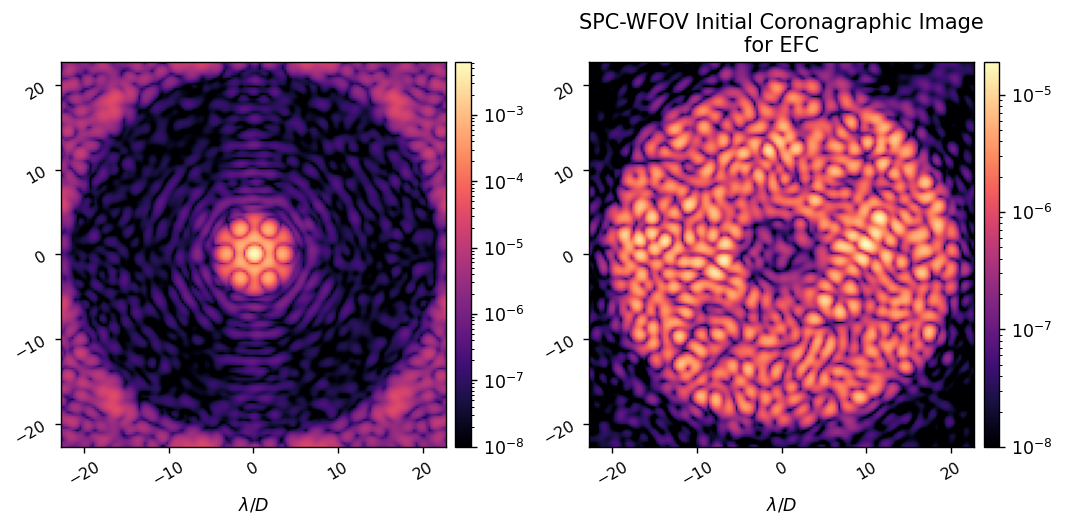

In [13]:
reload(cgi_phasec_poppy.cgi)
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=150,
                                  use_pupil_defocus=True, 
                                  use_opds=True,
                                  dm1_ref=2*dm1_flat,
                                # dm2_ref=dm2_flat,
                                  dm1_shift=np.array([0.00011,0]),
                                  dm2_shift=np.array([-0.00011,0]),
                                #   dm1_rot = 0.1,
                                #   dm2_rot = -0.1,
                                  )

mode.exp_times_list = None

# perturb model by slightly shifting the SPM
original_spm = copy.copy(mode.SPM.amplitude)
spm_amp = mode.SPM.amplitude
# mode.SPM.amplitude = _scipy.ndimage.shift(spm_amp, (5,0))
mode.SPM.amplitude = _scipy.ndimage.shift(original_spm, (5,0))
imshow3(original_spm, mode.SPM.amplitude, original_spm-mode.SPM.amplitude,
        'Original SPM', 'Shifted SPM','Difference')

mode.use_fpm = False
ref_unocc_im = mode.snap()

mode.Imax_ref = ensure_np_array(ref_unocc_im).max()
mode.use_fpm = True

ref_im = mode.snap()

reload(utils)
control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)

print(xp.mean(ref_im[control_mask]))
imshow2(ref_unocc_im, ref_im, '', 'SPC-WFOV Initial Coronagraphic Image\nfor EFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm1=True, lognorm2=True, vmin1=1e-8, vmin2=1e-8)

# Create calibration and probe modes

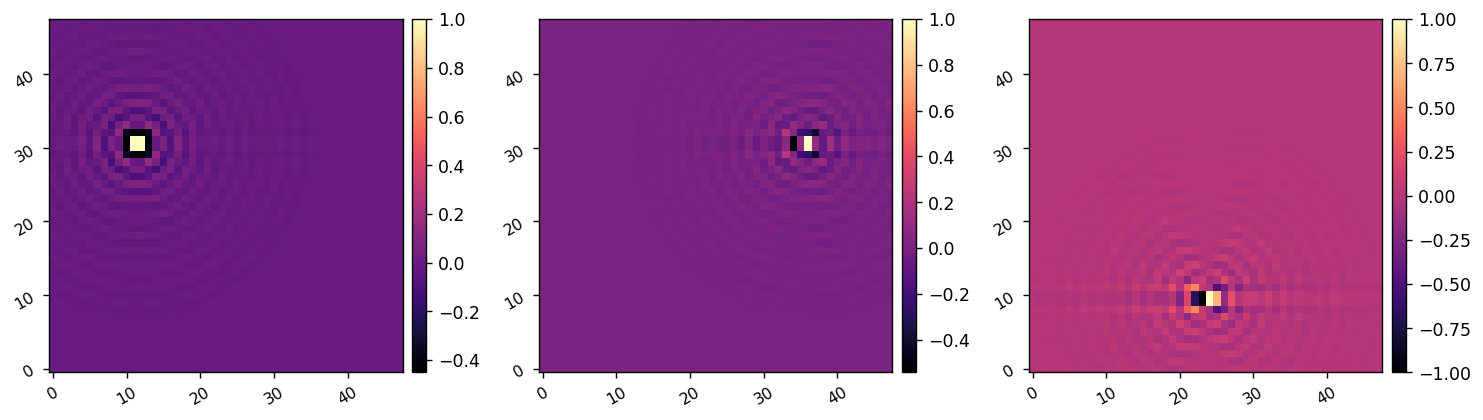

In [9]:
calib_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=2)

probe_amp = 20e-9
# probe_modes = utils.create_poke_probes([(10,34), (38,34), (24,10)], plot=True)
# probe_modes = utils.create_poke_probes([(11,31), (36,31), (23,9)], plot=True)
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.25,
                                          shift=[(-12,7), (12,7),(0,-14), (0,0)], nprobes=3,
                                          use_weighting=True)
imshow3(probe_modes[0], probe_modes[1], probe_modes[2],)

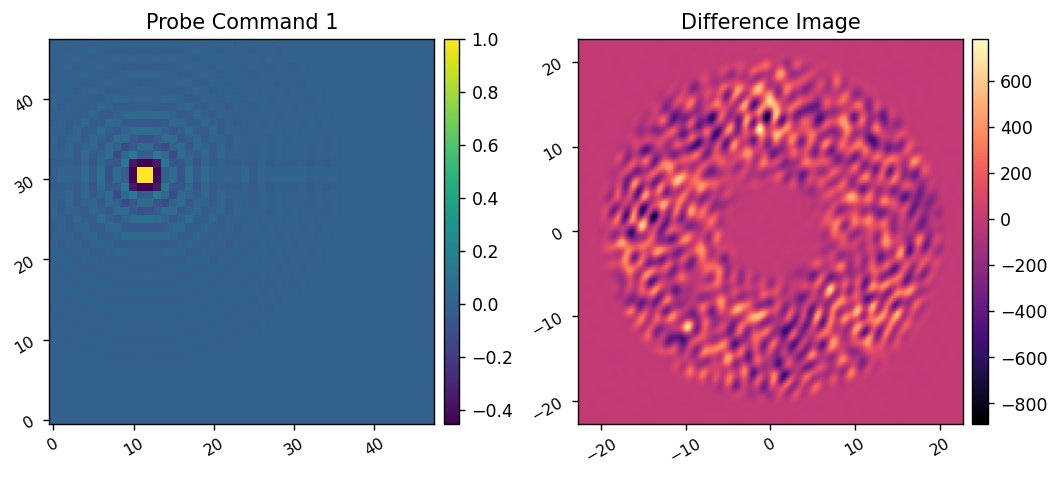

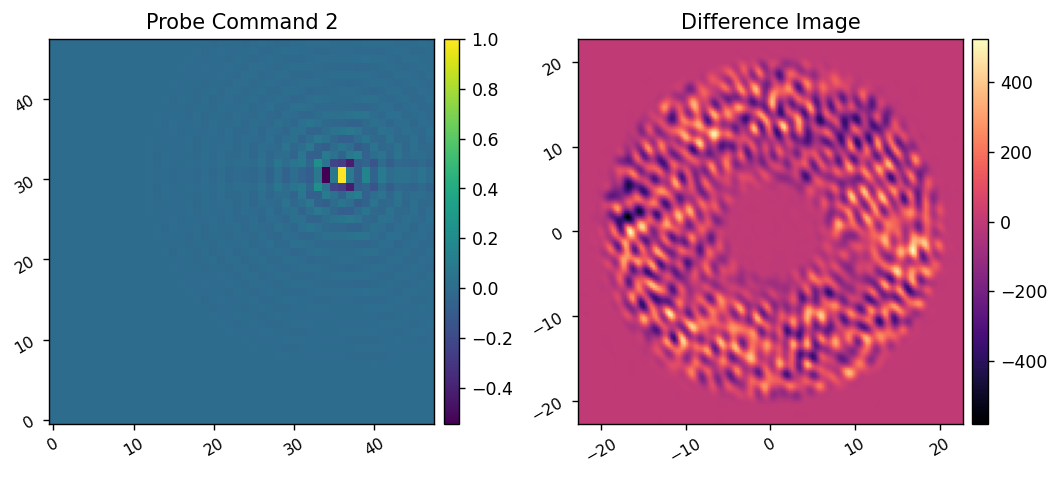

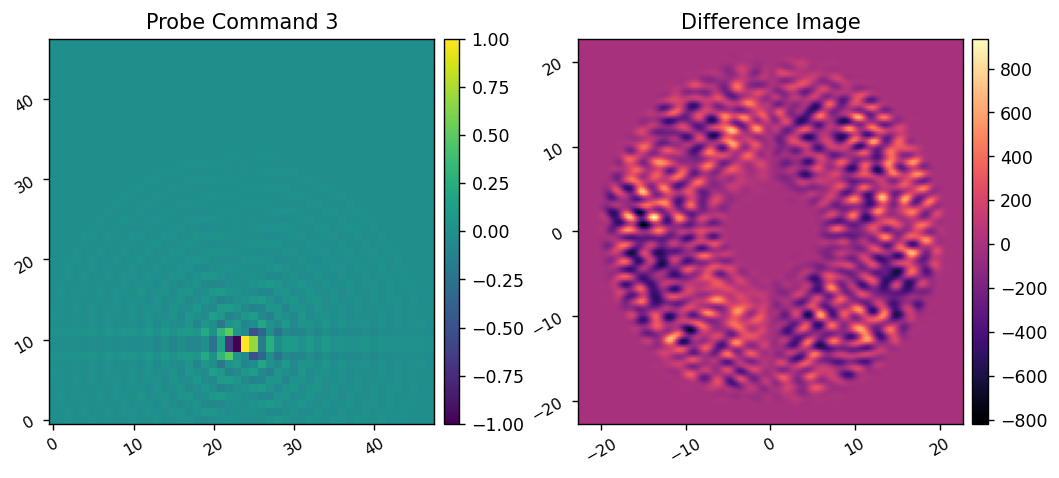

In [7]:
reload(iefc_2dm)

differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True, plot=True)
ims = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)

In [ ]:
reload(iefc_2dm)

calib_amp = 5e-9

response_matrix, response_cube = iefc_2dm.calibrate(mode, 
                                                    control_mask,
                                                    probe_amp, probe_modes, 
                                                     calib_amp, calib_modes[:2], 
                                                     return_all=True, 
#                                                     plot_responses=False,
                                                   )

utils.save_fits(response_dir/f'test_response_matrix_{today}.fits', response_matrix)
utils.save_fits(response_dir/f'test_response_cube_{today}.fits', response_cube)


9780182646457.285


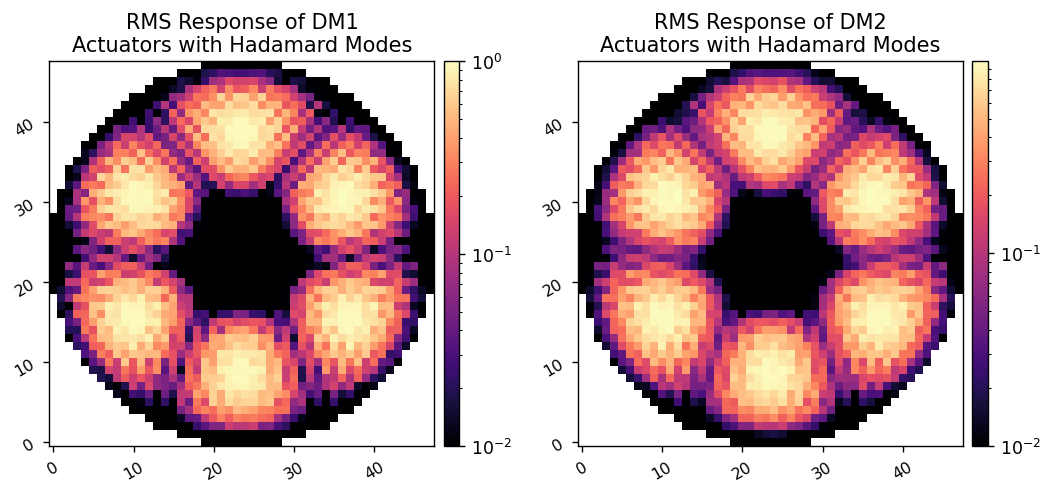

In [10]:

# date = 20230912
# date = 20230913
# date = 20230918
# date = 20230925
date = 20231009
date = 20231010
date = 20231016
date = 20240109
date = 20240131
response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_825_had_modes_perturbed_response_matrix_{date}.fits'))

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm_response.max()
dm2_response = dm_response[mode.Nact**2:].reshape(mode.Nact, mode.Nact)/dm_response.max()

print(dm_response.max())
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1\nActuators with Hadamard Modes', 'RMS Response of DM2\nActuators with Hadamard Modes',
        lognorm=True, vmin1=0.01, vmin2=0.01,
        )

# Run IEFC

In [22]:
mode.reset_dms()

images = xp.array([ref_im])
dm1_commands = xp.array([mode.get_dm1()])
dm2_commands = xp.array([mode.get_dm2()])
regs = xp.array([])

Running iEFC...
	Closed-loop iteration 28 / 30
False
False


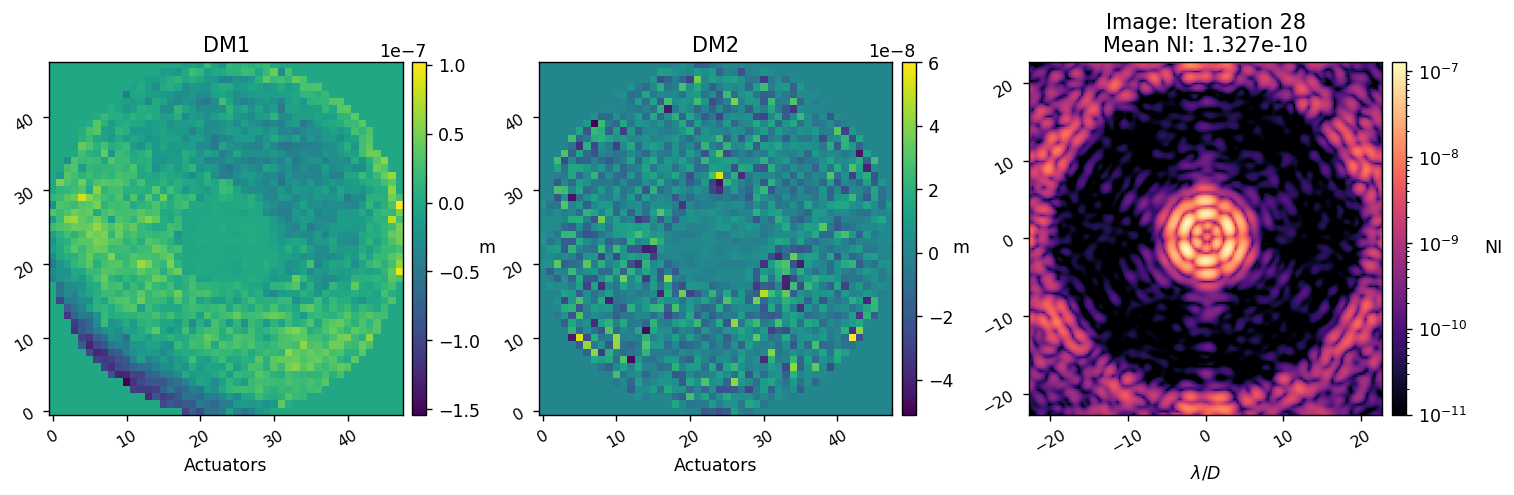

	Closed-loop iteration 29 / 30
False
False


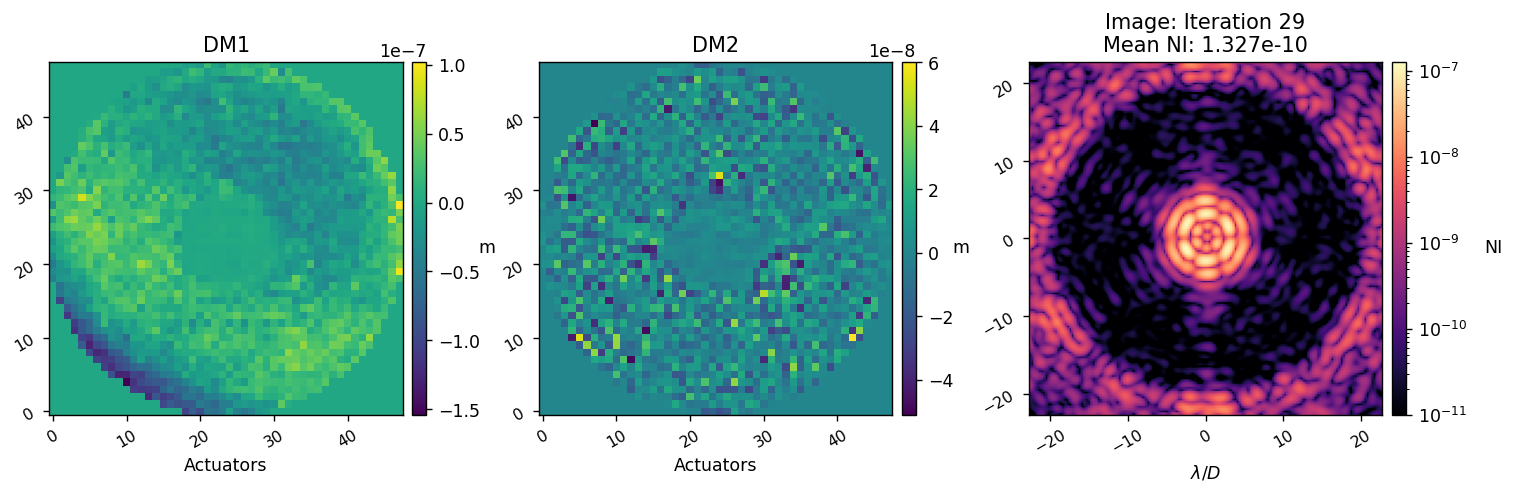

	Closed-loop iteration 30 / 30
False
False


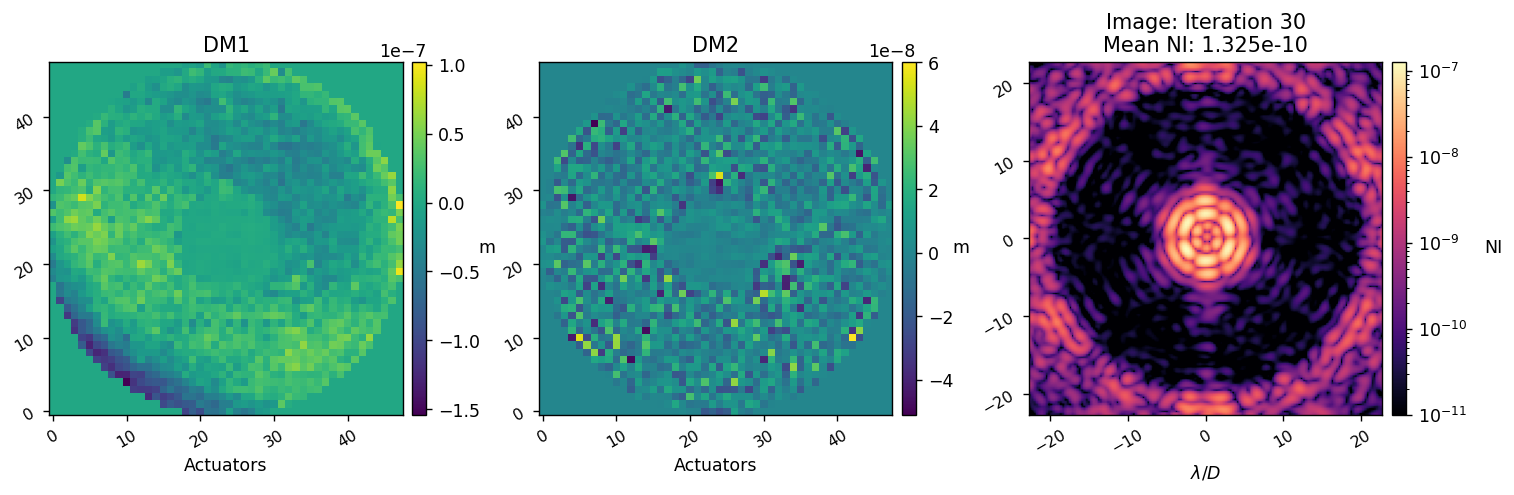

Closed loop for given control matrix completed in 8.791s.


In [32]:
reload(iefc_2dm)
reload(utils)

reg_fun = utils.beta_reg
reg_conds = -2.5
reg_conds = -4
# reg_conds = -5
# reg_conds = -6

probe_amp = 2.5e-9

images, dm1_commands, dm2_commands, regs = iefc_2dm.run(mode, 
                                                        # control_matrix,
                                                        response_matrix,
                                                        reg_fun, reg_conds,
                                                        probe_modes, 
                                                        probe_amp, 
                                                        calib_modes,
                                                        control_mask, 
                                                        num_iterations=3, 
                                                        loop_gain=0.5, 
                                                        leakage=0,
                #                                                   use_fourier_filter=True,
                                                        plot_all=True,
                                                        plot_radial_contrast=False,
                                                        old_images=images,
                                                        old_dm1_commands=dm1_commands,
                                                        old_dm2_commands=dm2_commands,
                                                        old_regs=regs,
                                         )


In [33]:
utils.save_fits(response_dir/f'spc_wfov_825_had_dm1_commands_perturbed_{today}.fits', dm1_commands)
utils.save_fits(response_dir/f'spc_wfov_825_had_dm2_commands_perturbed_{today}.fits', dm2_commands)
utils.save_fits(response_dir/f'spc_wfov_825_had_images_perturbed_{today}.fits', images)
utils.save_fits(response_dir/f'spc_wfov_825_had_regs_perturbed_{today}.fits', regs)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_had_dm1_commands_perturbed_20240201.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_had_dm2_commands_perturbed_20240201.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_had_images_perturbed_20240201.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_had_regs_perturbed_20240201.fits
